# Estimating COVID-19's $R_t$ in Real-Time with PYMC3
### MITRE Revised version, United States (National) only

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
import os
import io

In [3]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
mitre_cert = './mitre_cert.crt'
x = requests.get(url=url, verify=mitre_cert).content 
states = pd.read_csv(io.StringIO(x.decode('utf8')), 
                    parse_dates=['date'],index_col=['state', 'date']).sort_index()
# states = pd.read_csv(url,
#                      parse_dates=['date'],
#                      index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

In [4]:
states.head()

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   

                  ... hospitalized total totalTestResults posNeg  fips  \
state date        ...                                                    
AK    2020-03-06  ...          NaN     9                8      8     2   
      2020-03-07  ...          NaN    14               12     12     2   
      2020-03-08  ...          NaN    20               14     14     2   
      2020-03-09  ...          NaN    32               23     23     2   
      2020-03-10  ...          NaN    32               23     23     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  

[5 rows x 25 columns]

#### Clean data with known modifications

In [5]:
# Errors in Covidtracking.com
states.loc[('WA','2020-04-21'), 'positive'] = 12512
states.loc[('WA','2020-04-22'), 'positive'] = 12753 
states.loc[('WA','2020-04-23'), 'positive'] = 12753 + 190

states.loc[('VA', '2020-04-22'), 'positive'] = 10266
states.loc[('VA', '2020-04-23'), 'positive'] = 10988

states.loc[('PA', '2020-04-22'), 'positive'] = 35684
states.loc[('PA', '2020-04-23'), 'positive'] = 37053

states.loc[('MA', '2020-04-20'), 'positive'] = 39643

states.loc[('CT', '2020-04-18'), 'positive'] = 17550
states.loc[('CT', '2020-04-19'), 'positive'] = 17962

states.loc[('HI', '2020-04-22'), 'positive'] = 586

states.loc[('RI', '2020-03-07'), 'positive'] = 3

#### Integrity Check

In [6]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
AK   2020-05-18
AL   2020-05-18
AR   2020-05-18
AZ   2020-05-18
CA   2020-05-18
CO   2020-05-18
CT   2020-05-18
DC   2020-05-18
DE   2020-05-18
FL   2020-05-18
GA   2020-05-18
HI   2020-05-18
IA   2020-05-18
ID   2020-05-18
IL   2020-05-18
IN   2020-05-18
KS   2020-05-18
KY   2020-05-18
LA   2020-05-18
MA   2020-05-18
MD   2020-05-18
ME   2020-05-18
MI   2020-05-18
MN   2020-05-18
MO   2020-05-18
MS   2020-05-18
MT   2020-05-18
NC   2020-05-18
ND   2020-05-18
NE   2020-05-18
NH   2020-05-18
NJ   2020-05-18
NM   2020-05-18
NV   2020-05-18
NY   2020-05-18
OH   2020-05-18
OK   2020-05-18
OR   2020-05-18
PA   2020-05-18
RI   2020-05-18
SC   2020-05-18
SD   2020-05-18
TN   2020-05-18
TX   2020-05-18
UT   2020-05-18
VA   2020-05-18
VT   2020-05-18
WA   2020-05-18
WI   2020-05-18
WV   2020-05-18
WY   2020-05-18
Name: date, dtype: datetime64[ns]

state  date      
CO     2020-05-12   -20.0
Name: positive, dtype: float64

state  date      
HI     2020-05-15   -1.0
Name: positive, dtype: float64

state  date      
MA     2020-04-20   -177.0
Name: positive, dtype: float64

state  date      
MT     2020-05-05   -1.0
Name: positive, dtype: float64

state  date      
OH     2020-04-27   -264.0
Name: positive, dtype: float64

state  date      
VT     2020-05-11   -1.0
Name: positive, dtype: float64

state  date      
WA     2020-04-21   -268.0
       2020-05-18   -157.0
Name: positive, dtype: float64

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [7]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True, verify=mitre_cert) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
#     try:
    download_file(URL, LINELIST_PATH)
    clear_output(wait=True)
    print('Done downloading.')
#     except:
#         print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


In [8]:
#====NOTE - THIS CODE DOES NOT DOWNLOAD THE FILE CORREECTLY.
# Try downloading by pinging the url, then extract the tar file to linelist.csv
import urllib.request
import tarfile
URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz"
LINELIST_PATH = 'data/linelist.tar.gz'

response = requests.get(url, stream=True, verify=mitre_cert)
if response.status_code == 200:
    print('successfully retrieved file. Downloading to local.')
    with open(LINELIST_PATH, 'wb') as f:
        f.write(response.raw.read())


successfully retrieved file. Downloading to local.


#### Parse & Clean Patient Info

In [9]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

patients = patients[patients.Confirmed >= patients.Onset]

In [10]:
patients.head(5)

,Onset,Confirmed
53,2020-02-08,2020-02-14
55,2020-02-01,2020-02-13
335,2020-01-30,2020-02-14
365,2020-02-14,2020-02-16
446,2020-02-11,2020-02-15


#### Calculate the Probability Distribution of Delay

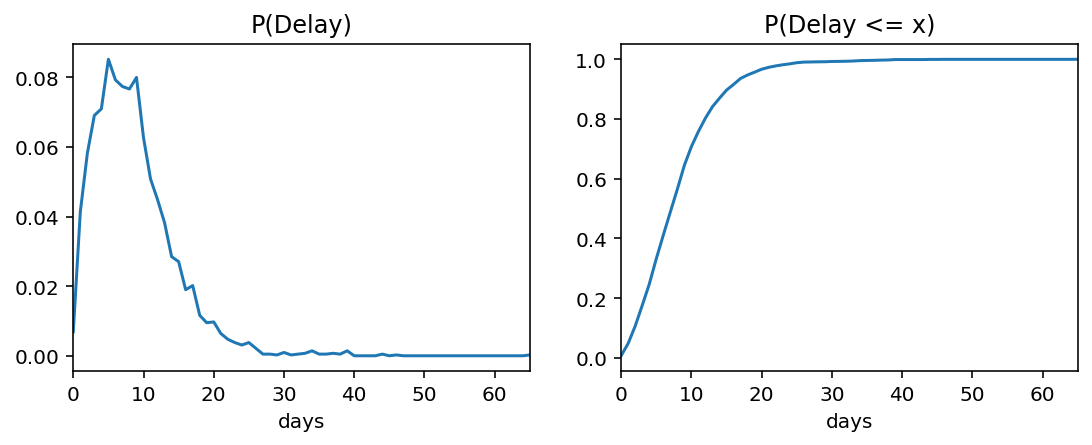

In [11]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [12]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [13]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        'constant',
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [89]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            # Original code could go negative
            """
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())
            """
            # Theta random walk
            # New Version
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            theta = pm.Deterministic('theta', -gamma+pm.math.abs_(theta_raw.cumsum()+gamma)) #ADDED HERE
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self

### Run Pymc3 Model

In [15]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

#### National

In [90]:
nat_cts = states.groupby('date').sum()
nat_cts
region = 'United States'
nat_model = create_and_run_model(region, nat_cts)
nat_res = df_from_model(nat_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:53<00:00, 74.29it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


In [91]:
nat_res.to_csv('data/rt_national_test10.csv', index=True)